# 0.0 Introduction
This notebook will describe an algorithm which will take in reduced spectra from the GAIA ESO survey and perform PCA. For the moment the only spectra used are from the GIARAFFE telescope using the HR10 setting.

# 0.1 First pass

The first pass will have no care for error. The formatting of the data is faily poor this is just to get something acceptable working. There is also no science behind the sample selection. What type of stars do we wish to look at, what brightness, intersetllar dust extinction. This is just taking a certain random sample of HR10 and seeing what we can learn. Consider
https://arxiv.org/pdf/1001.4340.pdf

# 0.2 Imports

In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Analysis" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting

from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train


os.chdir("Analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Analysis'

In [2]:
#plotting standards
sn.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

# 1.0 Data input for HR10 Sample

THE HR10 Giraffe spectra have been selected. We will use the data handling function to create a list of these
spectra with their object names. We will get a list of spectrum classes.


<p style="color:red;">Import the data file</p>

In [3]:
os.chdir('../')
from Data_handling.spectra_object import get_data
os.chdir('Parameter_files')
HR10=pd.read_csv('HR10_parameter_with_file_names_for_spectra.csv')
os.chdir('../Data')
HR10['spectrum']=HR10['hr10_file'].apply(get_data)

# 1.1 Parameters for these samples

Some of the parameters have been included in the above, to find out the specifics they will be in the spectra_object.py file.

# 1.2 Example of a spectra

In [4]:
spectrum=HR10['spectrum'][0]

Example of a spectrum

Plot of spectrum flux vs wavelength  
Units of wavelength are nm  
Units of flux are adu


### Next we are looking at sigma clipping values.

In [5]:
def fill_high_error_data(spectrum,n_sigma=3):
    try:    #technical thing
        median = spectrum['flux_err'].median()
        std=spectrum['flux_err'].std()
        bound=median+n_sigma*std
        outliers = (spectrum['flux_err'])>bound
        spectrum['flux'][outliers] = np.nan
        spectrum['flux']=spectrum['flux'].fillna(median)
        return spectrum
    except:
        return 0 #this is done if that there is no values in the spectrum we will dorp them later

<AxesSubplot:title={'center':'Plot of spectrum'}, xlabel='nm', ylabel='adu'>

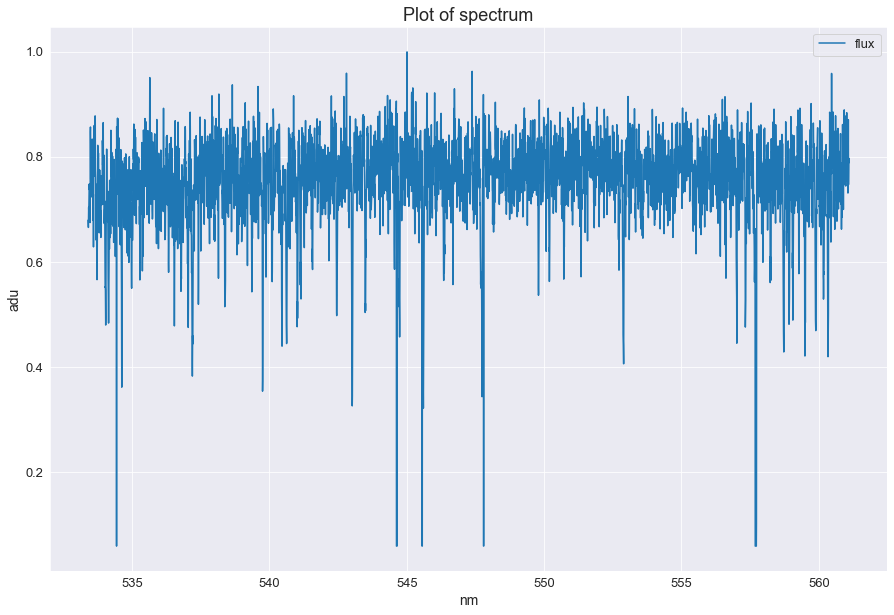

In [6]:

spectrum=fill_high_error_data(HR10['spectrum'][0])
scaler=sklearn.preprocessing.MaxAbsScaler()
def normalised_pca(list_X): 
    X_train_scaled = scaler.fit_transform(list_X)
    return X_train_scaled
spectrum['flux']=normalised_pca(spectrum['flux'].values.reshape(-1,1))
plt.figure(figsize=(15,10))
plt.title("Plot of spectrum")
plt.xlabel('nm')
plt.ylabel('adu')
sn.lineplot(x=spectrum['wavelength'],y=spectrum['flux'],label='flux')
#sn.lineplot(x=spectrum['wavelength'],y=spectrum['flux_err'],label='flux error')



NB: After this the xaxis isn't scaled labeled for the wavelength values. Needs to be changed.

# 1.3 Clean high error flux values from the spectrum.

In [7]:
HR10['spectrum']=HR10['spectrum'].apply(fill_high_error_data)

In [8]:
def row_type_isnt_int(row):
    return type(row)!=int

In [9]:
HR10=HR10[HR10['spectrum'].apply(row_type_isnt_int)]
#drop the spectrum indices with no values.

# 1.4 Signal to Noise Ratio Cut

### SNR is the signal to noise value given in the WG15 parameter files.

In [10]:
print('Fraction of SNR we will use')
sum(HR10['SNR']>=15.0)/sum(HR10['SNR']>=0.0)

Fraction of SNR we will use


0.536544080604534

Make the SNR cut:

In [11]:
HR10=HR10[HR10['SNR']>=20.0]

In [12]:
HR10.reset_index(inplace=True)

# 2.0 Principal C A

We first will normalise the data and the goal will be to do PCA on the normalised subset.

Take the same example of a spectrum and perform PCA on it.

In [13]:
learning_spectra=[]
for i in range(0,len(HR10['spectrum'])):
    print(i)
    learning_spectra.append(HR10['spectrum'][i]['flux'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
learning_spectra=np.array(learning_spectra)
np.shape(learning_spectra)

(20865, 5541)

Each row is a different spectra, of 5541 wavelength observations.

# 2.1 Algorithm setup

Define the PCA

In [15]:
pca=Pca_Fitting(learning_spectra,n_components=100)

The shape of our input spectra data is:

In [16]:
np.shape(learning_spectra)

(20865, 5541)

Fit to our data

spec_fitted is the PCA coefficients, where each row corresponds to a spectrum and the row vector describes the PCA coefficients associated to that spectrum. 

In [17]:
np.shape(pca.X_fitted)


(20865, 100)

### We should have low variance, what we can do now is plot the explained variacne per component, this will give us an idea of how many componenets explain the data.

In [18]:
pca.pca.explained_variance_ratio_

array([2.71950871e-01, 1.14769123e-01, 1.11022644e-01, 5.41773401e-02,
       5.07394038e-02, 3.09984703e-02, 3.02837864e-02, 2.61920244e-02,
       2.28820238e-02, 1.89381577e-02, 1.77630018e-02, 1.38395447e-02,
       1.18811522e-02, 1.13009261e-02, 8.95565562e-03, 7.88321812e-03,
       7.55295996e-03, 6.03812467e-03, 5.44903195e-03, 5.05924271e-03,
       4.13718447e-03, 3.58948717e-03, 3.38667026e-03, 2.86418386e-03,
       2.62690964e-03, 2.56393012e-03, 2.43907492e-03, 2.13244255e-03,
       2.02970137e-03, 2.01094197e-03, 1.81316014e-03, 1.75500801e-03,
       1.66455749e-03, 1.62362447e-03, 1.55762967e-03, 1.55099889e-03,
       1.28134736e-03, 1.24697865e-03, 1.17366842e-03, 1.15915004e-03,
       1.11499033e-03, 1.07816875e-03, 1.06515246e-03, 9.58807068e-04,
       9.33943840e-04, 9.07444686e-04, 8.81888904e-04, 8.49262811e-04,
       7.90291524e-04, 7.82242569e-04, 7.41095515e-04, 7.02490273e-04,
       6.91959867e-04, 6.63590909e-04, 6.15838624e-04, 5.91749093e-04,
      

### The next plot describes what the first few scaled spectra look like.

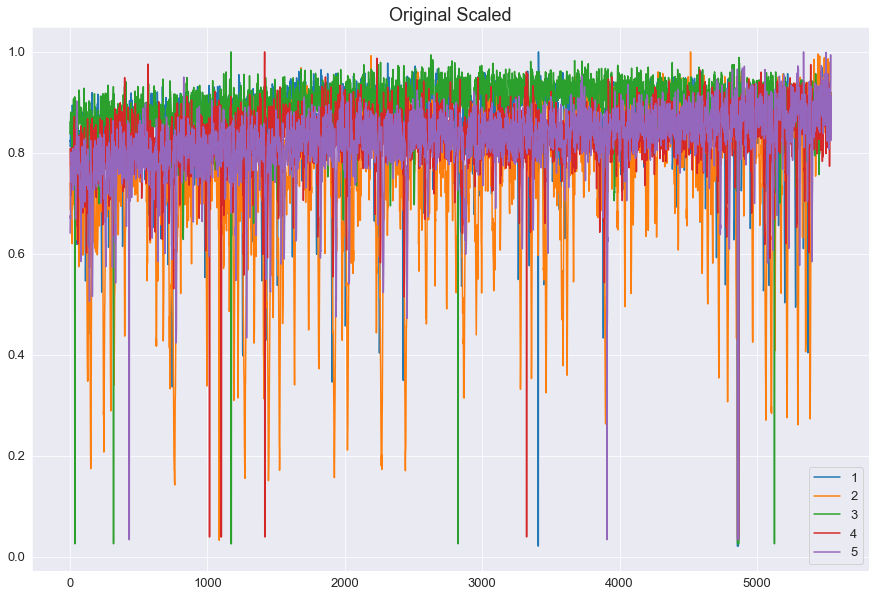

In [19]:
#Compare normalisation
plt.figure(figsize=(15,10))
pca.plot_normalised(1)
pca.plot_normalised(2)
pca.plot_normalised(3)
pca.plot_normalised(4)
pca.plot_normalised(5)

Comparing the reconstructed spectrum with the original.

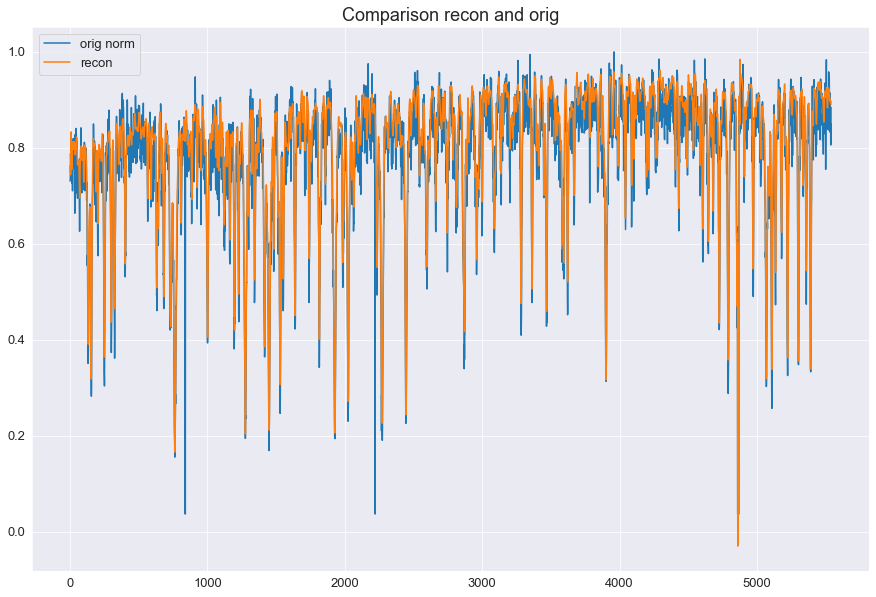

In [20]:
#example for first spectrum, the reconstructed spectrum is shifted up.
plt.figure(figsize=(15,10))
pca.plot_orig_and_recon_w_offset(6)

So this seems to be working okay. 

# 2.2 Analysis of PCA Fit

What we are going to do is refit the PCA with 100 components and then analyse the explained variance ratio per component to see the fit.

In [21]:
#pca=Pca_Fitting(learning_spectra,n_components=10)


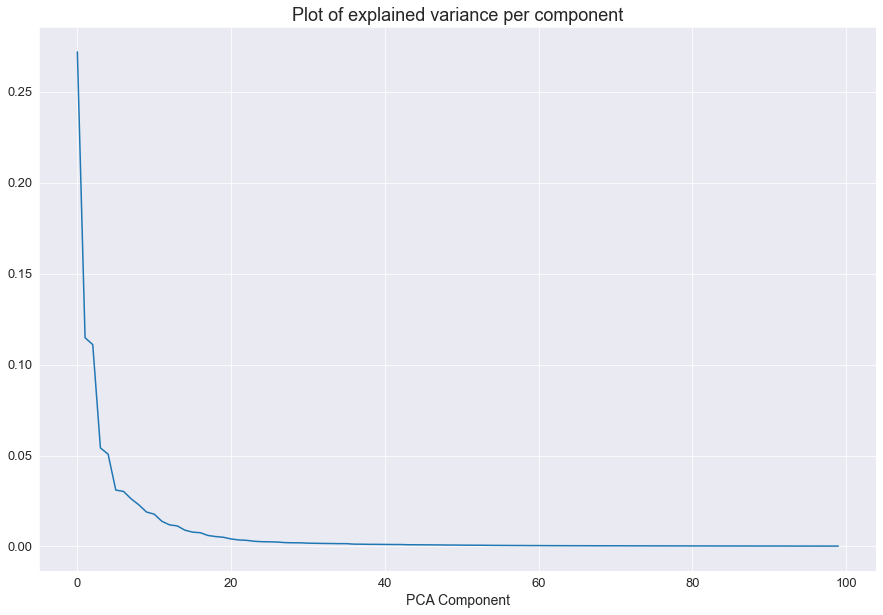

In [22]:
plt.figure(figsize=(15,10))
plt.title('Plot of explained variance per component')
plt.xlabel('PCA Component')
plt.plot(pca.pca.explained_variance_ratio_)

We can see there is a significant increase in goodness of fit after 3 components are used in PCA.

# Analysis of individual parts

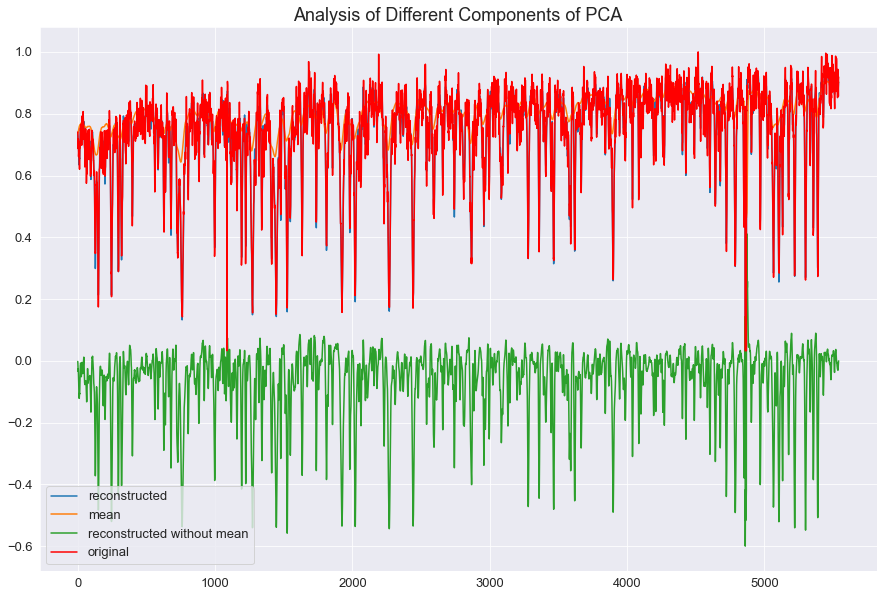

In [23]:
plt.figure(figsize=(15,10))
plt.plot(pca.reconstructed_X[2],label='reconstructed')
plt.plot(pca.pca.mean_,label='mean')
plt.plot(pca.reconstructed_X[2]-pca.pca.mean_,label='reconstructed without mean')
plt.plot(pca.learning_X[2],label='original',color='r')
plt.title('Analysis of Different Components of PCA')
plt.legend()

# 2.3 Analysis of Components
In what follows the practice will be very poor. We will utilise that the indices will be in the same order in spectrum_list[i] as in the learning_spectrum list. In future we need a better way of keeping track. The code above will need to be reviewed and changed.

## 2.3.1 Analysis of PCA Components



In [24]:
columns=list(HR10['spectrum'][0]['wavelength'].astype(str))

In [25]:

pca_coeff=pd.DataFrame(data=pca.X_fitted)

analysis=HR10.loc[:, HR10.columns != 'spectrum']

Relationship between the first and second PCA coefficients for each spectra.


$$ \vec{x}_i=\vec{\mu}+(AB)_i$$
where the index $i$ corresponds to a row in the matrix learning_spectra. Moreover, $A$ is the 1090 by 100 matrix spec_fitted, $B$ is the 100 by 5541 matrix pca.pca.components_.    

The above equation seems to be able to succesfuly reconstruct the spectra. Below I plot the first column of A against the second column of A.

In [26]:
param=['DIST_GAIA','TEFF', 'LOGG', 'FEH', 'VRAD']#, 'XI']

# Cuts for analysis.

<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

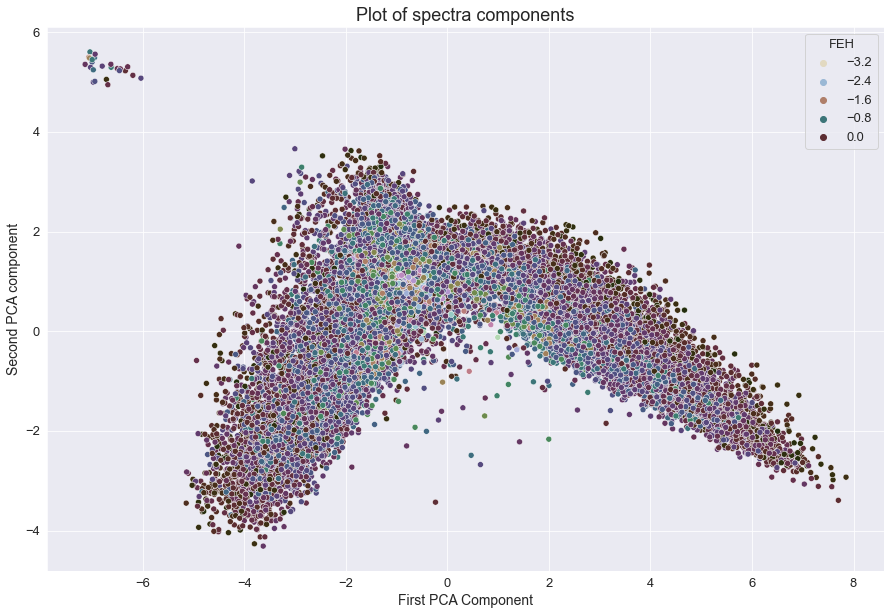

In [27]:
i=3
pca_analysis=pd.concat([analysis[param],pca_coeff],axis=1)
pca_analysis=pca_analysis[pca_analysis[param[i]]!='nan']

pca_analysis[param[i]]=pca_analysis[param[i]].astype(float)

plt.figure(figsize=(15,10))
sn.scatterplot(data=pca_analysis,x=2,y=6, hue=param[i], palette="ch:r=-3,l=0.9")

plt.title('Plot of spectra components')
plt.ylabel('Second PCA component')
plt.xlabel('First PCA Component')

sn.heatmap

In [28]:
pca_analysis=pca_analysis[pca_analysis['VRAD']<=200]
pca_analysis=pca_analysis[pca_analysis['VRAD']>=-200]
pca_analysis=pca_analysis[pca_analysis['VRAD']<=6500]
pca_analysis=pca_analysis[pca_analysis['VRAD']>=-4000]

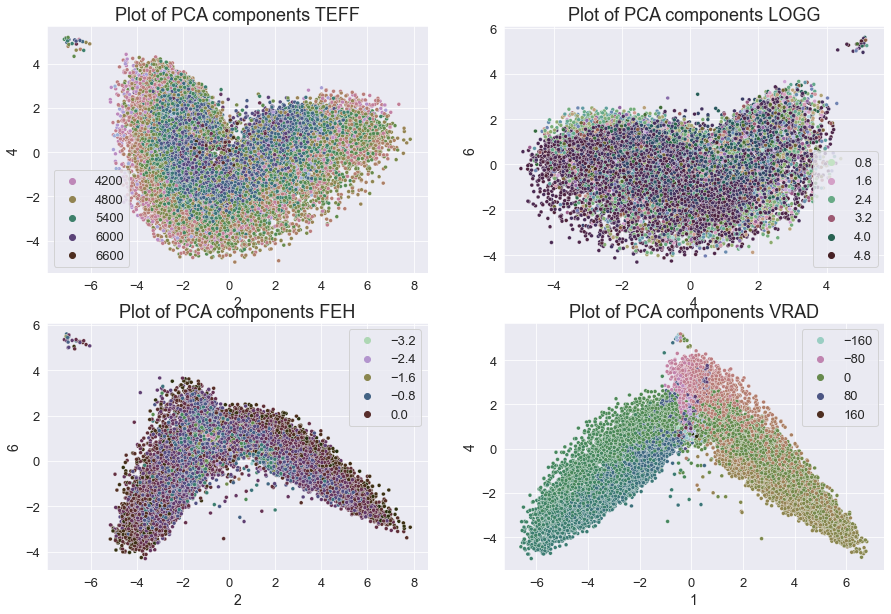

In [29]:
fig, axs = plt.subplots(2,2)


fig.set_figheight(10)
fig.set_figwidth(15)
#axs[0,0].axhline(10,color='r')
axs[0,0].set_title('Plot of PCA components TEFF')
sn.scatterplot(data=pca_analysis,x=2,y=4, hue=param[1], palette="ch:r=-3,l=0.7",ax=axs[0,0],s=15)
axs[0,0].legend()

axs[0,1].set_title('Plot of PCA components LOGG')
sn.scatterplot(data=pca_analysis,x=4,y=6, hue=param[2], palette="ch:r=-4,l=.9",ax=axs[0,1],s=15)
axs[0,1].legend()

axs[1,0].set_title('Plot of PCA components FEH')
sn.scatterplot(data=pca_analysis,x=2,y=6, hue=param[3], palette="ch:r=-3,l=.8",ax=axs[1,0],s=15)
axs[1,0].legend()

axs[1,1].set_title('Plot of PCA components VRAD')
sn.scatterplot(data=pca_analysis,x=1,y=4, hue=param[4], palette="ch:r=-3,l=.8",ax=axs[1,1],s=15)
axs[1,1].legend()


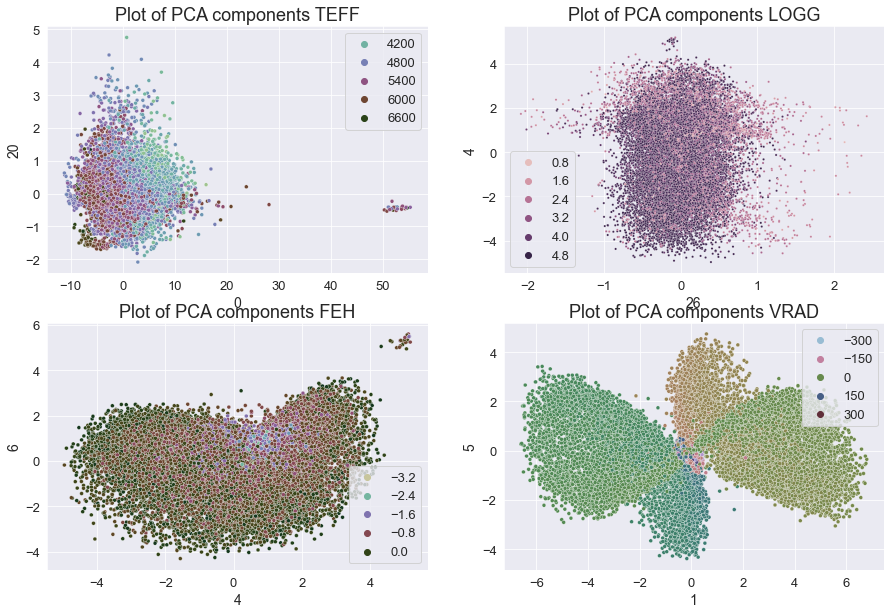

In [49]:
fig, axs = plt.subplots(2,2)


fig.set_figheight(10)
fig.set_figwidth(15)
#axs[0,0].axhline(10,color='r')
axs[0,0].set_title('Plot of PCA components TEFF')
sn.scatterplot(data=pca_analysis,x=0,y=20, hue=param[1], palette="ch:r=-2,l=.7",ax=axs[0,0],s=15)
axs[0,0].legend()

axs[0,1].set_title('Plot of PCA components LOGG')
sn.scatterplot(data=pca_analysis,x=26,y=4, hue=param[2],ax=axs[0,1],s=5)
axs[0,1].legend()

axs[1,0].set_title('Plot of PCA components FEH')
sn.scatterplot(data=pca_analysis,x=4,y=6, hue=param[3], palette="ch:r=-2,l=.8",ax=axs[1,0],s=15)
axs[1,0].legend()

axs[1,1].set_title('Plot of PCA components VRAD')
sn.scatterplot(data=pca_analysis,x=1,y=5, hue=param[4], palette="ch:r=-3,l=.8",ax=axs[1,1],s=15)
axs[1,1].legend()


In [31]:
import sklearn.cluster as skl_cluster

model = skl_cluster.SpectralClustering(n_clusters=3, affinity='nearest_neighbors', assign_labels='kmeans')
#pca_analysis['cluster'] = model.fit_predict(pca_analysis[[0,1]])

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


# Correlation

In [32]:
pca_analysis=pd.concat([analysis[param],pca_coeff],axis=1)
corr=pca_analysis.corr().loc[param]
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_8654/3800126517.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,DIST_GAIA,TEFF,LOGG,FEH,VRAD,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
DIST_GAIA,1.00,-0.04,0.07,-0.03,-0.06,0.07,0.05,-0.00,-0.07,-0.00,0.01,-0.01,0.04,-0.06,0.01,0.03,-0.03,-0.01,0.01,-0.02,-0.02,0.01,-0.03,0.03,0.00,-0.01,0.02,0.00,0.02,-0.03,0.03,0.01,0.05,0.00,-0.02,0.04,-0.01,0.01,0.00,0.01,0.00,0.03,0.01,-0.01,0.04,-0.04,0.02,-0.02,-0.02,0.03,0.01,0.02,0.04,0.01,-0.01,-0.01,-0.00,-0.00,0.02,-0.02,-0.03,0.01,-0.02,-0.01,0.03,-0.05,0.01,-0.01,-0.00,-0.02,-0.02,0.00,0.00,-0.02,-0.00,-0.03,0.01,-0.01,0.00,-0.02,0.01,0.01,-0.00,-0.01,0.01,0.01,0.01,0.02,0.01,0.01,-0.01,-0.01,0.02,-0.03,-0.02,-0.02,-0.01,0.00,0.00,-0.04,-0.02,0.01,-0.00,-0.00,0.02
TEFF,-0.04,1.00,0.47,0.01,0.06,-0.51,-0.02,-0.05,0.04,0.08,-0.02,0.13,0.24,0.25,-0.11,-0.03,-0.01,-0.13,-0.04,-0.11,0.22,-0.06,-0.15,-0.04,-0.06,-0.21,0.09,0.06,-0.08,-0.00,0.00,-0.16,-0.01,0.08,-0.16,-0.05,-0.02,-0.17,0.02,0.08,-0.03,0.01,-0.03,-0.10,-0.02,0.00,0.02,-0.06,-0.05,0.01,0.01,-0.04,-0.02,0.01,0.04,0.02,-0.00,-0.02,0.02,-0.00,-0.02,-0.04,-0.04,0.02,-0.02,0.05,-0.07,0.03,-0.04,-0.02,-0.09,-0.06,-0.04,0.02,-0.05,0.01,0.02,-0.07,0.02,0.02,0.06,0.01,-0.02,0.00,-0.11,0.01,0.01,0.02,0.01,-0.06,-0.05,-0.05,0.01,0.09,0.01,-0.02,0.07,0.04,0.02,-0.04,0.03,-0.01,0.02,0.05,-0.03
LOGG,0.07,0.47,1.00,0.38,-0.08,-0.05,0.02,0.18,-0.09,-0.19,0.06,-0.15,0.22,0.26,0.17,-0.05,0.08,0.17,0.04,0.18,0.07,-0.06,-0.04,0.04,-0.01,-0.17,0.26,0.12,0.06,-0.03,0.05,-0.25,0.14,0.09,-0.14,-0.03,-0.00,-0.11,0.02,0.05,-0.07,0.02,0.02,-0.07,-0.06,-0.04,0.11,-0.12,-0.03,0.07,-0.01,-0.04,0.04,0.07,0.09,0.00,-0.01,-0.01,0.04,0.00,-0.07,-0.07,-0.12,0.03,0.01,0.03,-0.08,-0.00,-0.03,-0.02,-0.11,-0.07,-0.00,0.04,-0.04,-0.00,0.03,-0.07,0.05,0.03,0.07,0.01,0.02,0.02,-0.08,0.02,0.04,0.05,-0.01,-0.05,-0.06,-0.03,0.00,0.08,-0.01,-0.03,0.08,0.02,0.02,-0.02,0.05,0.03,0.01,0.06,-0.02
FEH,-0.03,0.01,0.38,1.00,-0.16,0.31,0.02,0.13,-0.08,-0.19,0.06,-0.20,-0.01,0.10,0.17,0.00,-0.00,0.19,0.08,0.12,-0.08,-0.01,0.09,-0.07,-0.09,0.01,-0.04,0.06,-0.18,0.31,0.08,-0.07,-0.14,0.12,-0.09,-0.05,-0.02,-0.01,0.08,0.03,0.01,-0.05,-0.08,0.05,0.01,0.02,-0.14,-0.01,0.01,-0.06,0.11,-0.06,-0.03,-0.00,0.02,-0.00,0.07,-0.03,0.01,0.01,0.08,-0.02,0.07,0.03,-0.03,0.10,-0.17,0.09,-0.12,0.03,-0.10,-0.05,0.02,0.05,-0.11,-0.02,0.02,-0.07,0.05,0.07,0.11,0.03,-0.04,-0.05,-0.09,0.02,-0.01,0.01,-0.00,-0.07,-0.08,-0.05,-0.03,0.10,0.01,-0.01,0.10,0.05,0.01,-0.03,0.05,-0.01,-0.01,0.06,-0.02
VRAD,-0.06,0.06,-0.08,-0.16,1.00,-0.08,-0.31,-0.02,0.34,-0.05,-0.26,-0.00,0.04,-0.03,-0.04,-0.22,0.11,0.02,-0.24,-0.09,0.11,0.18,-0.02,-0.01,0.15,-0.04,0.05,-0.14,0.01,-0.12,-0.02,0.03,-0.08,0.01,0.12,0.25,0.05,0.12,-0.09,0.01,-0.06,0.04,-0.04,0.14,0.03,-0.02,0.02,0.08,0.07,-0.05,-0.01,-0.11,0.10,-0.03,0.03,-0.01,0.01,-0.03,-0.14,-0.03,-0.02,-0.03,-0.04,-0.01,-0.06,-0.02,0.06,0.08,-0.03,-0.05,-0.01,-0.01,0.01,0.05,0.02,-0.04,0.03,0.04,0.00,0.04,0.07,-0.06,0.07,-0.08,-0.08,-0.00,-0.04,-0.06,0.06,-0.08,-0.03,0.02,-0.01,-0.01,-0.03,0.05,0.03,0.03,0.04,0.05,0.03,-0.06,0.02,-0.05,-0.03


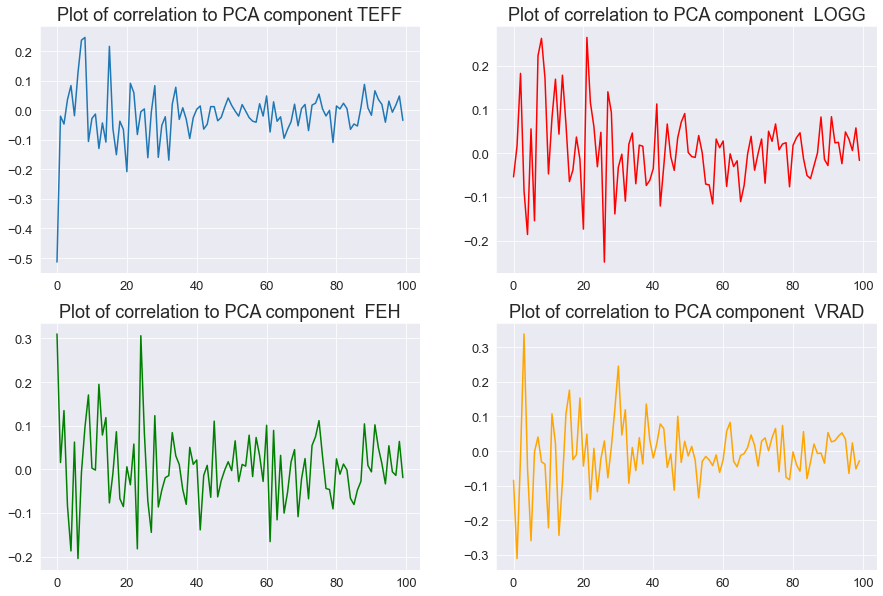

In [33]:

fig, axs = plt.subplots(2,2)


fig.set_figheight(10)
fig.set_figwidth(15)
#axs[0,0].axhline(10,color='r')
axs[0,0].set_title('Plot of correlation to PCA component TEFF')
axs[0,0].plot(corr.loc['TEFF'][5:])


axs[0,1].set_title('Plot of correlation to PCA component  LOGG')
axs[0,1].plot(corr.loc['LOGG'][5:],color='r')


axs[1,0].set_title('Plot of correlation to PCA component  FEH')
axs[1,0].plot(corr.loc['FEH'][5:],color='g')


axs[1,1].set_title('Plot of correlation to PCA component  VRAD')
axs[1,1].plot(corr.loc['VRAD'][5:],color='orange')



# Highest correlation components

TEFF

In [34]:
corr.loc['TEFF'][5:].sort_values()

0    -0.513684
20   -0.207541
32   -0.168531
26   -0.160258
29   -0.159011
        ...   
21    0.091783
6     0.126350
15    0.216763
7     0.237783
8     0.247061
Name: TEFF, Length: 100, dtype: float64

In [35]:
corr.loc['FEH'][5:].sort_values()

6    -0.204661
4    -0.187092
23   -0.182351
61   -0.165892
27   -0.144596
        ...   
2     0.134499
9     0.170336
12    0.194643
24    0.306171
0     0.310240
Name: FEH, Length: 100, dtype: float64

In [36]:
corr.loc['VRAD'][5:].sort_values()

1    -0.310462
5    -0.258890
13   -0.243384
10   -0.221736
22   -0.139788
        ...   
38    0.136065
19    0.153360
16    0.176107
30    0.245614
3     0.338488
Name: VRAD, Length: 100, dtype: float64

In [37]:
corr.loc['LOGG'][5:].sort_values()

26   -0.248550
4    -0.185648
20   -0.173315
6    -0.154412
29   -0.138738
        ...   
14    0.177875
2     0.182020
7     0.222218
8     0.261990
21    0.264125
Name: LOGG, Length: 100, dtype: float64